In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Load weather and traffic data
weather_data = np.load('./weather.npz', allow_pickle=True)['data']
traffic_data = np.load('./traffic.npz', allow_pickle=True)['data']
weather_data = weather_data[:, :, 1:]

def unpack_data(data):
    return np.reshape(data, [data.shape[0], data.shape[1] * data.shape[2]])

X = unpack_data(weather_data)
y = unpack_data(traffic_data)

# Using first 1/1000th of datasets
X = X[:len(X) // 100, :]
y = y[:len(y) // 100, :]
# Feature scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
Xtrain, testdata, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logytrain = np.log1p(ytrain)

In [2]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [5, 10, 15]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(Xtrain, logytrain)
best_rf = grid_search.best_estimator_

In [3]:
# Predict on the test data using the best RandomForestRegressor model
logytest_predict_rf = best_rf.predict(testdata)
ytest_predict_rf = np.expm1(logytest_predict_rf)
ytest_predict_rf = ytest_predict_rf.ravel()

In [4]:
# Using XGBoost
xgb_model = xgb.XGBRegressor(n_jobs=-1, random_state=42, early_stopping_rounds=10)  # Moved early_stopping_rounds to the constructor
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid={
    'n_estimators': [50, 100, 150],  # Increased number of estimators
    'learning_rate': [0.01, 0.05, 0.1],  # Increased number of learning rates
    'max_depth': [3, 5, 10],  # Increased number of max_depth values
}, cv=3, scoring='neg_mean_squared_error')  # Same number of cross-validation folds as before
grid_search_xgb.fit(Xtrain, logytrain, eval_set=[(testdata, np.log1p(ytest))], verbose=False)  # Removed early_stopping_rounds from fit() method
best_xgb = grid_search_xgb.best_estimator_

# Predict on the test data using the best XGBoost model
logytest_predict_xgb = best_xgb.predict(testdata)
ytest_predict_xgb = np.expm1(logytest_predict_xgb)
ytest_predict_xgb = ytest_predict_xgb.ravel()

In [5]:
from sklearn.metrics import mean_absolute_error

ytest = ytest.ravel()

rmse_rf = np.sqrt(mean_squared_error(ytest, ytest_predict_rf))
rmse_xgb = np.sqrt(mean_squared_error(ytest, ytest_predict_xgb))

mae_rf = mean_absolute_error(ytest, ytest_predict_rf)
mae_xgb = mean_absolute_error(ytest, ytest_predict_xgb)

print("Root Mean Squared Error (Random Forest): {:.2f}".format(rmse_rf))
print("Root Mean Squared Error (XGBoost): {:.2f}".format(rmse_xgb))
print("Mean Absolute Error (Random Forest): {:.2f}".format(mae_rf))
print("Mean Absolute Error (XGBoost): {:.2f}".format(mae_xgb))


Root Mean Squared Error (Random Forest): 15.35
Root Mean Squared Error (XGBoost): 12.84
Mean Absolute Error (Random Forest): 5.68
Mean Absolute Error (XGBoost): 4.87


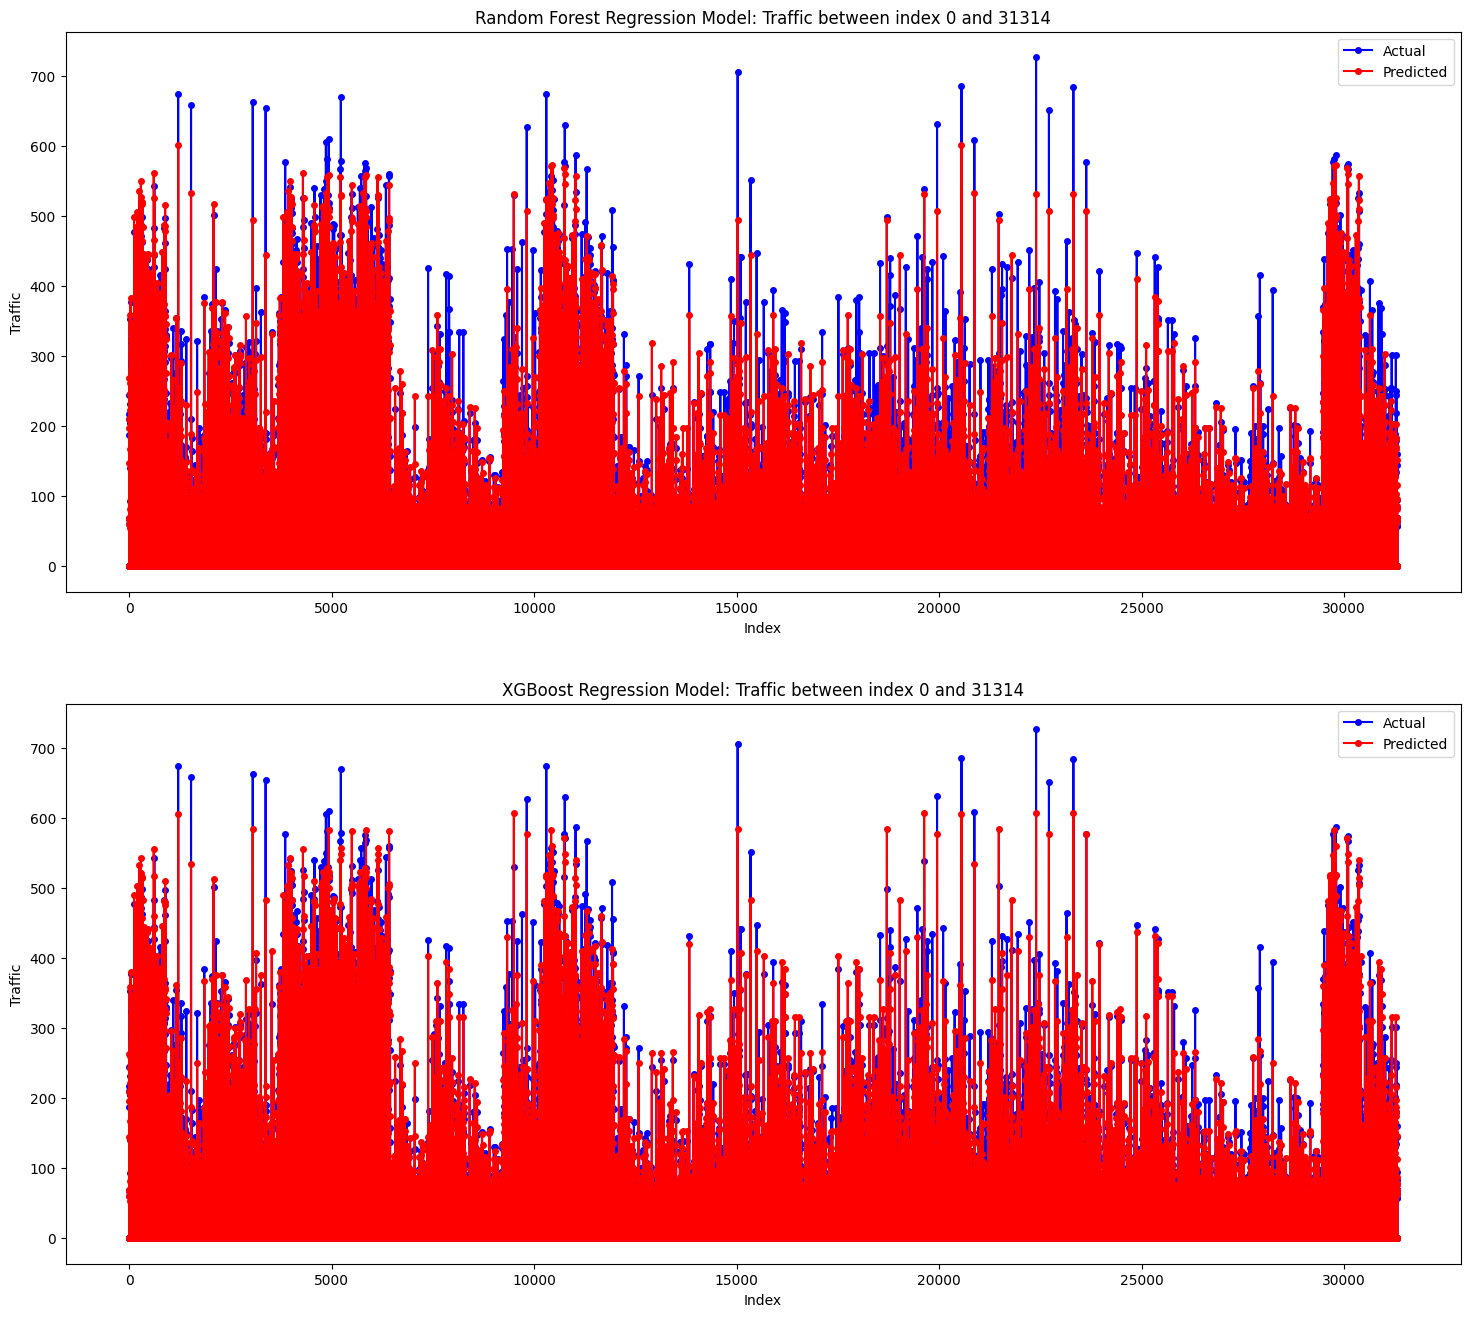

In [6]:
## Plot the results
algo_rf = 'Random Forest Regression'
algo_xgb = 'XGBoost Regression'
t_from, t_to = 0, len(ytest_predict_rf)
fig = plt.figure(figsize=(18, 16))

# Plot RandomForestRegressor
axes_rf = fig.add_subplot(2, 1, 1)
axes_rf.plot(ytest, label='Actual', marker='.', markersize=8, color='blue')
axes_rf.plot(ytest_predict_rf, label='Predicted', marker='.', markersize=8, color='red')
axes_rf.set(xlabel='Index', ylabel='Traffic', title='{0} Model: Traffic between index {1} and {2}'.format(algo_rf, t_from, t_to))
axes_rf.legend()

# Plot XGBoost
axes_xgb = fig.add_subplot(2, 1, 2)
axes_xgb.plot(ytest, label='Actual', marker='.', markersize=8, color='blue')
axes_xgb.plot(ytest_predict_xgb, label='Predicted', marker='.', markersize=8, color='red')
axes_xgb.set(xlabel='Index', ylabel='Traffic', title='{0} Model: Traffic between index {1} and {2}'.format(algo_xgb, t_from, t_to))
axes_xgb.legend()

plt.show()